# **LSTM Autoencoder 기반 클러스터링을 이용한 시계열 표준 패턴 추출 (1)**

### 창원대 전자공학과 20145234 황주효 (Hwang Ju-hyo, Department of Electronic Engineering, Changwon University)
---

과정은 다음과 같다.
1. 기준 패턴 설정 및 유사 패턴 추출
2. LSTM Autoencoder 모델링 및 학습
3. T-SNE 및 UMAP 압축 및 시각화 비교
4. k-memoids 클러스터링 및 표준 패턴 플로팅

## **1. 기준 패턴 설정 및 유사 패턴 추출**
---

* 사용할 모듈 및 데이터 불러오기

In [19]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import ts_dist
import pyximport # pyximport.install()
import seaborn as sns
from ts_dist import dtw_dist as dtw_dist_py
from ts_dist import lcss_dist as lcss_dist_py
from ts_dist import edr_dist as edr_dist_py
from datetime import datetime

def load_data():
    data = pd.read_csv('data_new.csv')
    date = datetime.strptime(data['data_date'][0], '%Y-%m-%d %H:%M:%S.%f').strftime('%m/%d/%Y')
    date = pd.DataFrame(data['data_date'])
    data['date'] = date.applymap(str).applymap(lambda s: '{}-{}-{} {}:{}:{}'.format(
        s[0:4], s[5:7], s[8:10],s[11:13],s[14:16],s[17:19]))
    data.index = pd.to_datetime(data['date'])
    data = data.drop(columns = ['data_date', 'date'])
    data = data['2020-12-09 00:00:00':'2020-12-09 23:59:59'] # # 2020-12-09일자 데이터 슬라이싱
    data.columns = ['oil_temperature']
    
    scaler = MinMaxScaler()
    data_s = scaler.fit_transform(data)
    data_s = pd.DataFrame(data_s)
    data_s.columns = data.columns
    data_s.index = data.index
    return data_s

data = load_data()

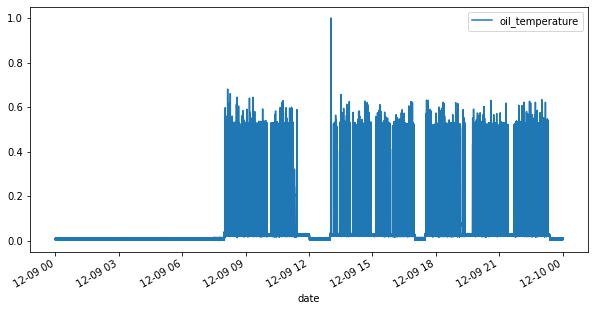

In [6]:
data.plot(figsize = (10, 5))
plt.show()

* 아래와 같은 패턴들을 확인할 수 있다.

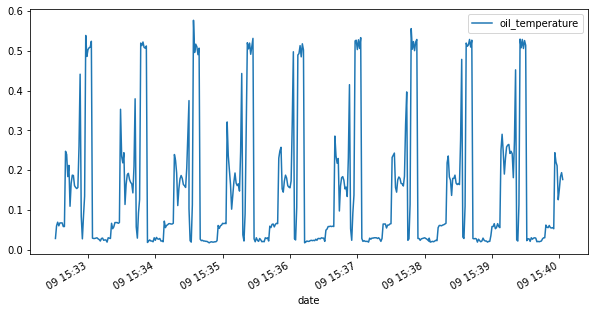

In [9]:
data['2020-12-09 15:32:31':'2020-12-09 15:40:04'].plot(figsize = (10, 5))
plt.show()

### **기준 패턴 설정**

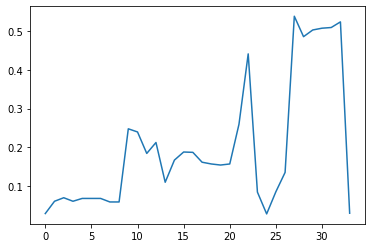

In [22]:
WINDOW_SIZE = 34
data_search = data['2020-12-09 15:32:31':'2020-12-09 15:33:04'].reset_index(drop=True)
plt.plot(data_search)
plt.show()

### EDR 유사도 측정 및 유사 패턴 추출

In [25]:
def execute_ts_als(data, data_search, al, delta = np.inf, epsilon = 0.5):
    from operator import itemgetter
    import time
    
    data = data
    data_search = data_search
    data_cal = 0
    find = []
    exe_time = 0
    delta = delta
    epsilon = epsilon
    
    if al == 'edr' : # EDR
        
        start = time.time()  # 시작 시간 저장
        for i in range(0, int((len(data)+1))):
            if i+WINDOW_SIZE <= len(data):
                data_cal = data.iloc[i:i+WINDOW_SIZE,]
                edr = edr_dist_py(data_search.T, data_cal.T, epsilon = epsilon) # 낮출수록 민감해진다
                diction = {'data_cal':data_cal, 'edr':edr, 'start_index': i}
                find.append(diction)
        exe_time = time.time() - start    
        
        find_sorted = sorted(find, key=itemgetter('edr'))

        edr_list = []
        for i in range(len(find_sorted)):
            edr_list.append(find_sorted[i]['edr'])

        index_list = []
        for i in range(len(find_sorted)):
            index_list.append(find_sorted[i]['start_index'])

        edr_list = pd.Series(edr_list)
        index_list = pd.Series(index_list)

        listed=  pd.concat((edr_list, index_list), axis = 1)
        listed.columns = ['edr', 'index_list']
        listed = listed.sort_values(by = 'index_list').reset_index(drop = True)
        listed = listed.drop(columns = 'index_list')
        
        return [exe_time, listed]
        
    if al == 'lcss' : # LCSS
        
        start = time.time()  # 시작 시간 저장
        for i in range(0, int((len(data)+1))):
            if i+WINDOW_SIZE <= len(data):
                data_cal = data.iloc[i:i+WINDOW_SIZE,]
                edr = lcss_dist_py(data_search.T, data_cal.T,delta = delta, epsilon = epsilon)
                diction = {'data_cal':data_cal, 'edr':edr, 'start_index': i}
                find.append(diction)
        exe_time = time.time() - start   
        
        find_sorted = sorted(find, key=itemgetter('edr'))

        edr_list = []
        for i in range(len(find_sorted)):
            edr_list.append(find_sorted[i]['edr'])

        index_list = []
        for i in range(len(find_sorted)):
            index_list.append(find_sorted[i]['start_index'])

        edr_list = pd.Series(edr_list)
        index_list = pd.Series(index_list)

        listed=  pd.concat((edr_list, index_list), axis = 1)
        listed.columns = ['lcss', 'index_list']
        listed = listed.sort_values(by = 'index_list').reset_index(drop = True)
        listed = listed.drop(columns = 'index_list')
        
        return [exe_time, listed]
    
    if al == 'dtw' : # DTW
        
        import fastdtw.fastdtw
        
        start = time.time()  # 시작 시간 저장
        for i in range(0, int((len(data)+1))):
            if i+WINDOW_SIZE <= len(data):
                data_cal = data.iloc[i:i+WINDOW_SIZE,]
                edr = fastdtw.fastdtw(data_search, data_cal)[0]
                diction = {'data_cal':data_cal, 'edr':edr, 'start_index': i}
                find.append(diction)
        exe_time = time.time() - start   
        
        find_sorted = sorted(find, key=itemgetter('edr'))

        edr_list = []
        for i in range(len(find_sorted)):
            edr_list.append(find_sorted[i]['edr'])

        index_list = []
        for i in range(len(find_sorted)):
            index_list.append(find_sorted[i]['start_index'])

        edr_list = pd.Series(edr_list)
        index_list = pd.Series(index_list)

        listed=  pd.concat((edr_list, index_list), axis = 1)
        listed.columns = ['dtw', 'index_list']
        listed = listed.sort_values(by = 'index_list').reset_index(drop = True)
        listed = listed.drop(columns = 'index_list')
        
        return [exe_time, listed]

In [26]:
[edr_time, edr_list] = execute_ts_als(data, data_search, 'edr', epsilon = 0.7)

* 기준 패턴과 70% 이상 일치하는 패턴들을 추출하고 정제한다.

In [29]:
w = 20
index = []
min_ = []
tempsss = []
i = 0

while (i < len(edr_list)):
    if data.iloc[i: i+20, ].max().values > 0.2:
        if edr_list.iloc[i,:].values[0] < 0.3:
            temp = edr_list.iloc[i:i+w]
            tempsss = temp
            if edr_list.iloc[i,:].values[0] == temp.min().values[0]:
                min_.append(edr_list.iloc[i,:].values[0])
                index.append(i)
                i = i+34
            else:
                i = i+1
        else:
            i = i+1
    else:
        i = i+1
print('{}개의 패턴 중 기준 패턴과 80% 이상 일치하는 패턴 {}개 추출됨'.format(len(edr_list), len(index)))

85779개의 패턴 중 기준 패턴과 80% 이상 일치하는 패턴 600개 추출됨


In [30]:
index = pd.DataFrame(index)
min_ = pd.DataFrame(min_)
con = pd.concat((index, min_), axis = 1)
con.columns = ['index_num', 'edr']
con

,index_num,edr
0,28715,0.294118
1,28843,0.294118
2,29013,0.294118
3,29208,0.205882
4,29527,0.205882
...,...,...
595,83099,0.000000
596,83147,0.000000
597,83193,0.058824
598,83248,0.000000


* 추출된 패턴을 전체 데이터에서 확인 (추출된 패턴의 시작 인덱스는 빨간 점으로 표시)

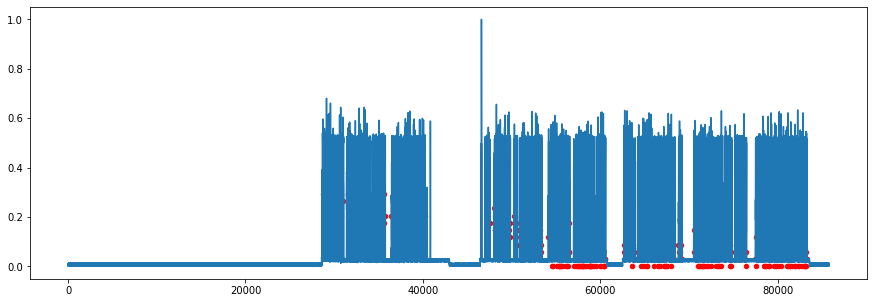

In [44]:
plt.figure(figsize = (15, 5))
plt.scatter(con['index_num'].values, con['edr'], c = 'r', s = 20)
plt.plot(range(len(data)), data)
plt.show()

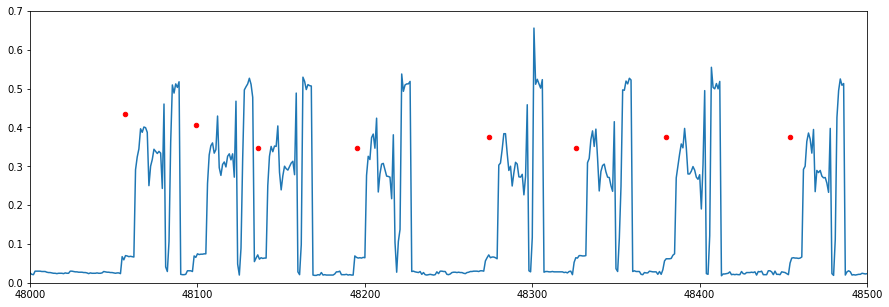

In [43]:
plt.figure(figsize = (15, 5))
plt.scatter(con['index_num'].values, con['edr']+0.2, c = 'r', s = 20)
plt.plot(range(len(data)), data)
plt.xlim(48000, 48500)
plt.ylim(0, 0.7)
plt.show()

In [46]:
data_reindex = data.reset_index(drop = True)
data_extract = pd.DataFrame()
for i in range(len(con)):
    data_extract = pd.concat((data_extract,
                              data_reindex.iloc[con['index_num'][i]:con['index_num'][i]+34,].reset_index(drop=True).T), axis = 0)

data_extract = data_extract.reset_index(drop=True)

* 추출된 패턴을 Pickle 모듈로 저장

In [48]:
import pickle

data_extract = np.array(data_extract)
X = data_extract.reshape(data_extract.shape[0], 34, 1)
with open("data.pickle","wb") as fw:
    pickle.dump(X, fw)